## Data Description
This competition involves classifying street-level images from three major Turkish cities using Google Street View data.

---

## Dataset Overview
The dataset consists of street view images from **Istanbul**, **Izmir**, and **Ankara**, with approximately equal distribution among the cities. All images are captured from notable/recognizable areas within each city.

---

## Files
- **`train/`** - Directory containing training images  
- **`test/`** - Directory containing test images  
- **`train.csv`** - Training labels and file mappings  
- **`test.csv`** - Test file mappings (unlabeled)  

---

## Image Specifications
All images in both train and test sets share the following specifications:  
- **Resolution**: 640x640 pixels  
- **Pitch**: 20 degrees upward  
- **Field of View (FOV)**: 75 degrees  
- **Format**: JPG  
- **Type**: Outdoor scenes  
- **Source**: Google Street View  

---

## File Descriptions

### `train.csv`
Contains two columns:  
- `filename` - Name of the image file in the `train/` directory  
- `city` - Label indicating the city (**Istanbul**, **Izmir**, or **Ankara**)  

### `test.csv`
Contains two columns:  
- `filename` - Name of the image file in the `test/` directory  
- `city` - Empty column to be predicted  


## Importing Libraries
This section includes all necessary libraries for data processing, visualization, and deep learning model development.

### Libraries for Data Processing
- **numpy**: Numerical operations.
- **pandas**: Data manipulation and analysis.
- **os**: File and directory handling.
- **cv2 (OpenCV)**: Image processing and computer vision tasks.

### Libraries for Visualization
- **matplotlib.pyplot**: Data and image visualization.

### Libraries for Machine Learning
- **sklearn.preprocessing.LabelEncoder**: Encoding target labels.
- **sklearn.model_selection.train_test_split**: Splitting the dataset into training and testing sets.

### Libraries for Deep Learning
- **keras.layers**: Includes layers like Dense, Dropout, GlobalAveragePooling2D for model architecture.
- **tensorflow.keras.applications.EfficientNetV2S**: Pre-trained EfficientNetV2S model for transfer learning.
- **tensorflow.keras.models**: To define and manage models (`Model`, `Sequential`).
- **tensorflow.keras.optimizers.Adam**: Optimization algorithm.
- **tensorflow.keras.callbacks**: Callbacks like `EarlyStopping` and `ReduceLROnPlateau` for optimizing training.
- **tensorflow.keras.regularizers**: To add regularization to the model.

EfficientNetV2S, an advanced pre-trained model, is employed for feature extraction and classification.


In [6]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers 
from tensorflow import keras


## Data Processing and Image Loading

1. **Define Data Path**: Specify the path to the training `.csv` file.
2. **Load CSV**: Read the dataset into a pandas DataFrame.
3. **Initialize Lists**: Create `images` and `labels` to store processed data.
4. **Process Images**: 
   - Check if files exist and load them.
   - Resize images to **520x520 pixels**.
   - Append processed images and labels to the lists.
5. **Convert to Numpy**: Transform lists into numpy arrays for model training.

In [4]:

# Veri seti yolunu tanımlayın
train_data_path = "/kaggle/input/datathon-ai-qualification-round/train_data.csv"

# Veriyi yükleyin
train_data = pd.read_csv(train_data_path)

# Görseller ve etiketler için listeler oluşturun
images = []
labels = []

# Veriyi iterasyonla işleyin
for index, row in train_data.iterrows():
    img_path = os.path.join("/kaggle/input/datathon-ai-qualification-round/train/train", row['filename'])
    
    if not os.path.exists(img_path):
        print(f"Dosya bulunamadı: {img_path}")  # Hata mesajı
        continue
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Resim açılamadı: {img_path}")  # Resim açılmadıysa hata mesajı
        continue

    # Resmi yeniden boyutlandırın
    img = cv2.resize(img, (520, 520))
    images.append(img)
    labels.append(row['city'])

# Listeleri numpy array'e dönüştürün
images = np.array(images)
labels = np.array(labels)


## Data Preparation for Model Training

1. **Label Encoding**: 
   - Convert string labels to integer values using `LabelEncoder`.
   - Perform one-hot encoding to prepare labels for multi-class classification.

2. **Train-Test Split**: 
   - Split the dataset into training and validation sets using an 80-20 split.

3. **Dataset Creation**:
   - Use TensorFlow's **`tf.data.Dataset`** to create datasets for training and validation.
   - **Training Dataset**: Batched with size 64 and shuffled with a buffer size of 1000.
   - **Validation Dataset**: Batched with size 64, without shuffling.


In [5]:

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # String -> Integer
num_classes = len(label_encoder.classes_)  # Sınıf sayısı

# One-Hot Encoding
labels_one_hot = to_categorical(labels_encoded, num_classes)

X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(64).shuffle(buffer_size=1000)  # Her batch'te 64 örnek, shuffle için buffer size 1000

# Doğrulama veri seti: Sadece batch'leme uygulanır, shuffle gerekmez.
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(64)


## Data Augmentation and Dataset Preparation

### 1. **Data Augmentation Function**
- **Purpose**: Enhance training data by applying random transformations.
- **Transformations**:
  - **Cropping and Resizing**: Random cropping and scaling with padding to maintain dimensions.
  - **Flipping**: Random horizontal flipping.
  - **Brightness Adjustment**: Random changes in image brightness.
  - **Contrast Adjustment**: Random modifications to image contrast.
  - **Hue Adjustment**: Random alterations to image hue.

### 2. **Training Dataset**
- Create a TensorFlow dataset from training data.
- **Steps**:
  - Shuffle the dataset with a buffer size of 1000.
  - Apply the augmentation function using `map` with parallel calls for performance optimization.
  - Batch the data with a size of 64.
  - Prefetch batches to improve input pipeline efficiency.

### 3. **Validation Dataset**
- Create a TensorFlow dataset from validation data.
- **Steps**:
  - Batch the data with a size of 64.
  - Prefetch batches for efficient data loading.


In [6]:
def augment(image, label):
    seed = tf.random.uniform([2], minval=0, maxval=int(1e6), dtype=tf.int32)
    
    # Kırpma ve yeniden boyutlandırma (Başta yapılmalı)
    image = tf.image.random_crop(image, size=[520, 520, 3])
    scales = tf.random.uniform([], minval=0.9, maxval=1.1)
    new_height = tf.cast(520 * scales, tf.int32)
    new_width = tf.cast(520 * scales, tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, 520, 520)
    
    # Diğer augmentasyonlar
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.1, seed=seed)
    image = tf.image.stateless_random_hue(image, max_delta=0.05, seed=seed)

    return image, label

# Eğitim veri seti: Veriler gruplar halinde işlenir (batch). Karışıklık (shuffle) eklenir.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)  # Augmentasyon
    .batch(64)  # Batch
    .prefetch(tf.data.AUTOTUNE)
)

# Doğrulama veri seti: Sadece batch'leme uygulanır, shuffle gerekmez.
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (
    val_dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

## Model Creation: Transfer Learning with EfficientNetV2M

### 1. **Base Model**
- **Model**: EfficientNetV2M.
- **Weights**: Pretrained on ImageNet.
- **Input Shape**: `(520, 520, 3)`.
- **Include Top**: False (to exclude the classification head for customization).

### 2. **Layer Freezing**
- Freeze all layers except the last 50 for transfer learning.

### 3. **Custom Model Architecture**
- **Base Layers**: 
  - Use EfficientNetV2M as the backbone for feature extraction.
  - Add a `GlobalAveragePooling2D` layer to aggregate features spatially.
- **Fully Connected Layers**:
  - Include multiple dense layers with **activation functions**:
    - `SELU` for self-normalizing activation.
    - `ReLU` for non-linearity.
  - **Regularization**:
    - Apply L2 regularization to dense layers to reduce overfitting.
    - Add `BatchNormalization` after each dense layer for stable training.
  - **Dropout**:
    - Use 50% dropout for regularization between layers.
- **Output Layer**:
  - A dense layer with `softmax` activation to output probabilities for `num_classes = 3`.

### 4. **Callbacks**
- **EarlyStopping**: Stops training when validation performance stops improving for 8 epochs, restoring the best weights.
- **ReduceLROnPlateau**: Reduces learning rate by a factor of 0.5 if validation loss does not improve for 2 epochs (minimum learning rate: `1e-6`).


In [ ]:
# Sınıf sayısını tanımlayın
num_classes = 3  # Sınıfların sayısını belirtin

# EfficientNetV2M modelini yükle
base_model = tf.keras.applications.EfficientNetV2M(
    include_top=False,  # Sınıflandırma katmanını çıkar
    weights='imagenet',  # Önceden eğitilmiş ağırlıkları kullan
    input_shape=(520, 520, 3)  # Giriş boyutu
)

# Katmanları dondurmak (transfer learning için)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Modeli oluştur
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(256, activation='selu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    
    layers.Dense(num_classes, activation='softmax')  # Çıkış Katmanı
])

# Callbackler
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

## Model Compilation

- **Optimizer**: `Adam` optimizer.
  - This optimizer adapts the learning rate based on the moving average of past gradients, making it suitable for complex and noisy data.
- **Loss Function**: `'categorical_crossentropy'`.
  - Used for multi-class classification problems. This loss function measures the dissimilarity between the predicted probabilities and the actual labels.
- **Metrics**:
  - `'accuracy'`: Monitor the model's classification performance during training and validation.


In [ ]:
# Modeli derleme
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

### 1. **Training the Model**
- **Dataset**: 
  - `train_dataset`: Augmented training dataset with batch processing.
  - `val_dataset`: Validation dataset.
- **Epochs**: 10000 epochs are set for training. This number can be reduced based on validation performance.
- **Callbacks**:
  - `early_stopping`: Stops training if the validation loss does not improve for 8 epochs, restoring the best weights.
  - `reduce_lr`: Reduces learning rate by half if the validation loss does not improve for 2 epochs, helping the model converge faster.

### 2. **Predictions**
- After training, the model can be used to make predictions on the validation set.
- **Predictions**: Get the predicted probabilities for each class.
- **Post-processing**: Use the `label_encoder` to convert the predicted integer labels back to their original string labels.


In [7]:
# Modeli eğitme
history = model.fit(
    train_dataset,  # Augment edilmiş eğitim verileri
    validation_data=val_dataset,  # Doğrulama verileri
    epochs=10000,
    callbacks=[early_stopping, reduce_lr]
)

# Tahmin (Opsiyonel)
predictions = model.predict(val_dataset)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))


214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10000


I0000 00:00:1734272380.027674      70 service.cc:145] XLA service 0x7f6e54002d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734272380.027747      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734272517.580978      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.3536 - loss: 9.4274 - val_accuracy: 0.4950 - val_loss: 7.2914 - learning_rate: 0.0010
Epoch 2/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4837 - loss: 6.7061 - val_accuracy: 0.7829 - val_loss: 4.8136 - learning_rate: 0.0010
Epoch 3/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7157 - loss: 4.4327 - val_accuracy: 0.8557 - val_loss: 3.1828 - learning_rate: 0.0010
Epoch 4/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8166 - loss: 2.9611 - val_accuracy: 0.8786 - val_loss: 2.1849 - learning_rate: 0.0010
Epoch 5/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8475 - loss: 2.0875 - val_accuracy: 0.8793 - val_loss: 1.5918 - learning_rate: 0.0010
Epoch 6/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8627 - loss: 1.5039 - val_accuracy: 0.8786 - val_loss: 1.2043 - learning_rate: 0.0010
Epoch 7/10000
88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8916 - loss: 1.1086 - val_ac

## Plotting Training and Validation Metrics

This section plots the training and validation loss, as well as the accuracy during model training.

### 1. **Training and Validation Loss**
- **Plot**:
  - `history.history['loss']`: Training loss over epochs.
  - `history.history['val_loss']`: Validation loss over epochs.
- **Visualization**:
  - The graph shows the model's loss on both training and validation sets across epochs. A decrease in loss indicates model improvement.
  
### 2. **Training and Validation Accuracy**
- **Plot**:
  - `history.history['accuracy']`: Training accuracy over epochs.
  - `history.history['val_accuracy']`: Validation accuracy over epochs.
- **Visualization**:
  - The graph shows the model's accuracy on both training and validation sets across epochs. An increase in accuracy indicates that the model is learning to classify better.
  
### 3. **Layout Adjustment**
- `plt.tight_layout()`: Adjusts the layout to ensure that the plots are not overlapping.
- `plt.show()`: Displays the graphs.


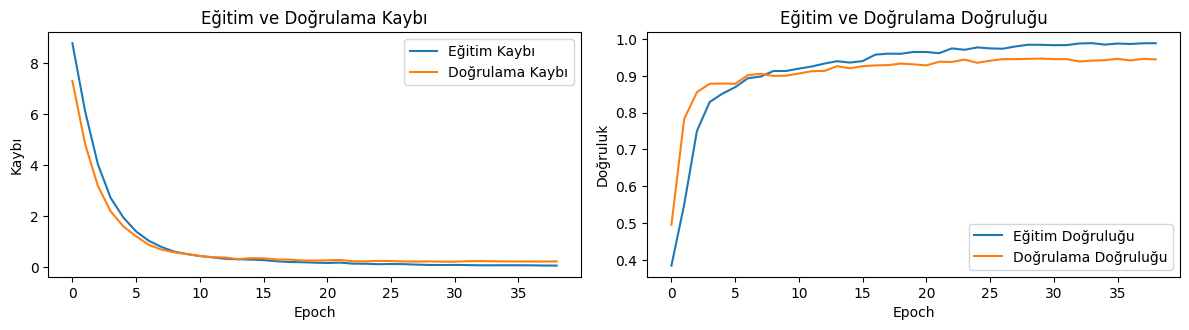

In [9]:

# Eğitim ve doğrulama kaybını çiz
plt.figure(figsize=(12, 6))

# Eğitim kaybı grafiği
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.ylabel('Kaybı')
plt.xlabel('Epoch')
plt.legend()

# Eğitim doğruluğu grafiği
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()

# Grafik alanını düzenle
plt.tight_layout()
plt.show()


## Loading and Preprocessing Test Data

### 1. **Test Data Path**
- The path to the test data is specified as `/kaggle/input/datathon-ai-qualification-round/test.csv`.
  
### 2. **Loading Test Data**
- `test_data = pd.read_csv(test_data_path)`: Reads the test data from a CSV file into a pandas DataFrame.
- Iterates through each row to construct the file paths for images based on the filenames listed in the CSV.

### 3. **Processing Each Image**
- For each image, its path is constructed and checked if the file exists:
  - If not, a warning is printed indicating the file is missing.
  - If the file exists, the image is read using `cv2.imread()`.
- If the image is read successfully:
  - It is resized to a standard size of `(520, 520)`.
  - The processed image is added to the list of images.
  - The corresponding label (city) is added to the labels list.

### 4. **Converting Lists to Numpy Arrays**
- `test_images = np.array(images)`: Converts the list of images to a numpy array.
- `test_labels = np.array(labels)`: Converts the list of labels to a numpy array.


In [10]:
# Test verisi yolunu belirtin
test_data_path = "/kaggle/input/datathon-ai-qualification-round/test.csv"

# Test verilerini yükleyin
test_data = pd.read_csv(test_data_path)

images = []
labels = []

# Test setindeki her bir dosya yolunu ve etiketini işleyin
for index, row in test_data.iterrows():
    img_path = os.path.join("/kaggle/input/datathon-ai-qualification-round/test/test", row['filename'])
    
    # Dosyanın var olup olmadığını kontrol edin
    if not os.path.exists(img_path):
        print(f"Dosya bulunamadı: {img_path}")  # Dosya bulunamadı uyarısı
    else:
        img = cv2.imread(img_path)
        
        # Resim başarılı bir şekilde okundu mu kontrol edin
        if img is None:
            print(f"Resim açılamadı: {img_path}")  # Resim açılamadı uyarısı
        else:
            # Görüntüyü yeniden boyutlandırın
            img = cv2.resize(img, (520, 520))
            images.append(img)
            labels.append(row['city'])

# Görüntü ve etiketleri numpy array'lerine dönüştürün
test_images = np.array(images)
test_labels = np.array(labels)


## Making Predictions

### 1. **Predicting with the Model**
- `predictions = model.predict(test_images)`: Uses the trained model to make predictions on the test images. This returns a list of predicted probabilities for each class.

### 2. **Classifying Predictions**
- `predicted_labels = np.argmax(predictions, axis=1)`: This function returns the index of the maximum value for each prediction, which corresponds to the predicted class. It is used to classify each image into one of the available classes (Istanbul, Izmir, or Ankara).


In [11]:
# Tahmin
predictions = model.predict(test_images)

# Tahminleri sınıflandırmak için argmax kullanabilirsiniz (örneğin, en yüksek olasılıklı sınıfı alır)
predicted_labels = np.argmax(predictions, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 641ms/step


## Class Names Mapping

### 1. **Class Names**
- `class_names = ['Ankara', 'Istanbul', 'Izmir']`: Defines the list of class names corresponding to each city.

### 2. **Class Mapping**
- `class_mapping = {i: name for i, name in enumerate(class_names)}`: Creates a mapping from class indices to class names. For example, index 0 corresponds to 'Ankara', index 1 to 'Istanbul', and index 2 to 'Izmir'.

### 3. **Translate Predictions**
- `predicted_classes = [class_mapping[label] for label in predicted_labels]`: Converts the predicted class indices into corresponding class names.
- `predicted_classes[:5]`: Shows the first five predictions as class names.


In [ ]:
# Sınıf isimleri
class_names = ['Ankara', 'Istanbul', 'Izmir']

# Sınıf haritası
class_mapping = {i: name for i, name in enumerate(class_names)}

# Tahminleri sınıf isimlerine çevirin
predicted_classes = [class_mapping[label] for label in predicted_labels]
predicted_classes[:5]

## Creating the Submission DataFrame

### 1. **Filename Column**
- `submission_df['filename'] = test_data['filename']`: Extracts the 'filename' column from the test dataset. This column contains the file names corresponding to each test image.

### 2. **Predicted City Column**
- `submission_df['city'] = predicted_classes`: Uses the predicted classes to populate the 'city' column in the DataFrame. Each entry corresponds to the predicted city for the corresponding image in the 'filename' column.

### 3. **Final DataFrame**
- `submission_df`: The resulting DataFrame that can be used for submission to the competition, containing both the image filenames and their corresponding predicted cities.


In [15]:
# DataFrame oluşturma
submission_df = pd.DataFrame({
    'filename': test_data['filename'],  # Test verilerinin filename sütununu al
    'city': predicted_classes  # Tahmin edilen şehirleri kullan
})


### Saving the Submission File

1. **Path Definition**:
   - `submission_path = '/kaggle/working/submission.csv'`: Defines the file path where the submission CSV will be saved. It is located in the `/kaggle/working/` directory.

2. **Saving the DataFrame**:
   - `submission_df.to_csv(submission_path, index=False)`: Writes the `submission_df` DataFrame to a CSV file at the specified path. The `index=False` parameter ensures that the DataFrame index is not written to the CSV file.

3. **Confirmation**:
   - `print(f"Submission dosyası başarıyla oluşturuldu: {submission_path}")`: Prints a confirmation message with the path of the saved submission file.


In [16]:
# CSV dosyasını /kaggle/working dizinine kaydetme
submission_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission dosyası başarıyla oluşturuldu: {submission_path}")

Submission dosyası başarıyla oluşturuldu: /kaggle/working/submission.csv


### Importing the Submission File

1. **Path Definition**:
   - `submission_path = '/kaggle/working/submission.csv'`: Specifies the path to the submission file saved earlier.

2. **Loading the CSV File**:
   - `submission_df = pd.read_csv(submission_path)`: Reads the submission file into a Pandas DataFrame named `submission_df`.

3. **Checking the DataFrame Shape**:
   - `submission_df.shape`: Retrieves the shape of the DataFrame, which provides the number of rows and columns in the submission file. This helps to confirm the successful loading of the file.


In [17]:

# submission.csv dosyasını içe aktarma
submission_path = '/kaggle/working/submission.csv'
submission_df = pd.read_csv(submission_path) 

submission_df.shape


(2000, 2)

In [18]:
submission_df

,filename,city
0,image_17000.jpg,Izmir
1,image_17001.jpg,Izmir
2,image_17002.jpg,Istanbul
3,image_17003.jpg,Istanbul
4,image_17004.jpg,Izmir
...,...,...
1995,image_18995.jpg,Istanbul
1996,image_18996.jpg,Izmir
1997,image_18997.jpg,Ankara
1998,image_18998.jpg,Istanbul
